In [3]:
import os

In [4]:
import pandas as pd
import chardet
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import optuna


ModuleNotFoundError: No module named 'optuna'

In [2]:
warnings.filterwarnings('ignore')

df = pd.read_excel('fs_test_data.xlsx')
df


,Date,price,promotion,region,type,revenue
0,2004-02-22,25.360000,0,reg1,tblre,6907.0
1,2004-02-29,25.490000,0,reg1,tblre,4350.0
2,2004-03-07,25.190000,0,reg1,tblre,3833.0
3,2004-03-14,25.700000,0,reg1,tblre,3746.0
4,2004-03-21,25.710000,0,reg1,tblre,4302.0
...,...,...,...,...,...,...
3547,2008-04-20,66.915054,0,reg4,vinta,NaN
3548,2008-04-27,51.401790,0,reg4,vinta,NaN
3549,2008-05-04,37.639410,0,reg4,vinta,NaN
3550,2008-05-11,47.990068,0,reg4,vinta,NaN


In [3]:
df.describe()

,Date,price,promotion,revenue
count,3552,3552.000000,3552.000000,2720.000000
mean,2006-04-05 12:00:00,40.773254,0.024493,3551.444118
min,2004-02-22 00:00:00,10.190217,0.000000,144.000000
25%,2005-03-13 00:00:00,27.180000,0.000000,825.750000
50%,2006-04-05 12:00:00,27.700000,0.000000,1680.000000
75%,2007-04-29 00:00:00,51.810833,0.000000,4648.000000
max,2008-05-18 00:00:00,156.194117,1.000000,21911.000000
std,NaN,28.366466,0.154596,4072.064694


In [4]:
def prepare_date(df):
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['week'] = df['Date'].dt.isocalendar().week
    df['week_sin'] = np.sin(2 * np.pi * df['week'] / 12)
    df['week_cos'] = np.cos(2 * np.pi * df['week'] / 12)
    
    lags = [1, 2, 3, 4, 8, 12, 16, 24]
    for lag in lags:
        df[f'revenue_lag_{lag}'] = df.groupby(['region', 'type'])['revenue'].shift(lag)
        
    windows = [4, 8, 12, 16]
    for window in windows:
        df[f'revenue_rolling_mean_{window}'] = df.groupby(['region', 'type'])['revenue'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df[f'revenue_rolling_std_{window}'] = df.groupby(['region', 'type'])['revenue'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
        df[f'revenue_rolling_min_{window}'] = df.groupby(['region', 'type'])['revenue'].transform(
            lambda x: x.rolling(window, min_periods=1).min()
        )
        df[f'revenue_rolling_max_{window}'] = df.groupby(['region', 'type'])['revenue'].transform(
            lambda x: x.rolling(window, min_periods=1).max()
        )
    
    for window in [4, 8]:
        df[f'revenue_rolling_trend_{window}'] = df.groupby(['region', 'type'])[f'revenue_rolling_mean_{window}'].transform(
            lambda x: (x - x.shift(window)) / x.shift(window)
        )
    df = df.set_index('Date')
    return df


def prepare_categorical_data(df):
    df_encoded = df.copy()
    encoder = OneHotEncoder(sparse_output=False, drop=None, dtype=int)
    
    categorical_data = df[['type', 'region']]
    encoded_array = encoder.fit_transform(categorical_data)
    feature_names = encoder.get_feature_names_out(['type', 'region'])
    
    encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df.index)
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    df_encoded = df_encoded.drop(columns=['type', 'region'])
    
    return df_encoded, encoder

def fill_revenue_nan(df):
    df_filled = df.copy()
    df_filled['revenue'] = df_filled['revenue'].interpolate(method='time')
    return df_filled

#вроде не нужно скейлить ничего в timeseries, но для некоторых моделей нужно только признаки
def scale_price(df):
    num_cols = ['price']
    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df


def prepare_data(df, target_col, test_start, test_end):
    feature_columns = [col for col in df.columns if col != target_col]
    
    train_mask = (df.index < test_start)
    test_mask = (df.index >= test_start) & (df.index <= test_end)
    
    x_train = df.loc[train_mask, feature_columns]
    y_train = df.loc[train_mask, target_col]
    
    x_test = df.loc[test_mask, feature_columns]
    y_test = df.loc[test_mask, target_col]
        
    return x_train, x_test, y_train, y_test, feature_columns
    
def full_prep(df):
    df = prepare_date(df)
    df, onehot_encoder = prepare_categorical_data(df)
    df = fill_revenue_nan(df)
    df = scale_price(df)
    x_train, x_test, y_train, y_test, feature_columns = prepare_data(df, 'revenue',
    test_start='2006-05-28',
    test_end='2007-05-20')
    return df, x_train, x_test, y_train, y_test, feature_columns




In [5]:
df, x_train, x_test, y_train, y_test, feature_columns = full_prep(df)

In [6]:
df

,price,promotion,revenue,year,month,month_sin,month_cos,week,week_sin,week_cos,...,revenue_rolling_trend_4,revenue_rolling_trend_8,type_tblre,type_tblwt,type_value,type_vinta,region_reg1,region_reg2,region_reg3,region_reg4
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-22,0.103900,0,6907.0,2004,2,0.866025,5.000000e-01,8,-0.866025,-0.5,...,NaN,NaN,1,0,0,0,1,0,0,0
2004-02-29,0.104790,0,4350.0,2004,2,0.866025,5.000000e-01,9,-1.0,-0.0,...,NaN,NaN,1,0,0,0,1,0,0,0
2004-03-07,0.102735,0,3833.0,2004,3,1.000000,6.123234e-17,10,-0.866025,0.5,...,NaN,NaN,1,0,0,0,1,0,0,0
2004-03-14,0.106229,0,3746.0,2004,3,1.000000,6.123234e-17,11,-0.5,0.866025,...,NaN,NaN,1,0,0,0,1,0,0,0
2004-03-21,0.106297,0,4302.0,2004,3,1.000000,6.123234e-17,12,-0.0,1.0,...,-0.412516,NaN,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-04-20,0.388516,0,15844.0,2008,4,0.866025,-5.000000e-01,16,0.866025,-0.5,...,NaN,NaN,0,0,0,1,0,0,0,1
2008-04-27,0.282264,0,15844.0,2008,4,0.866025,-5.000000e-01,17,0.5,-0.866025,...,NaN,NaN,0,0,0,1,0,0,0,1
2008-05-04,0.188003,0,15844.0,2008,5,0.500000,-8.660254e-01,18,0.0,-1.0,...,NaN,NaN,0,0,0,1,0,0,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3552 entries, 2004-02-22 to 2008-05-18
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    3552 non-null   float64
 1   promotion                3552 non-null   int64  
 2   revenue                  3552 non-null   float64
 3   year                     3552 non-null   int32  
 4   month                    3552 non-null   int32  
 5   month_sin                3552 non-null   float64
 6   month_cos                3552 non-null   float64
 7   week                     3552 non-null   UInt32 
 8   week_sin                 3552 non-null   Float64
 9   week_cos                 3552 non-null   Float64
 10  revenue_lag_1            2720 non-null   float64
 11  revenue_lag_2            2720 non-null   float64
 12  revenue_lag_3            2720 non-null   float64
 13  revenue_lag_4            2720 non-null   float64
 14  revenu

Random Forest MAPE: 0.1173 (11.73%)
Random Forest RMSE: 1215


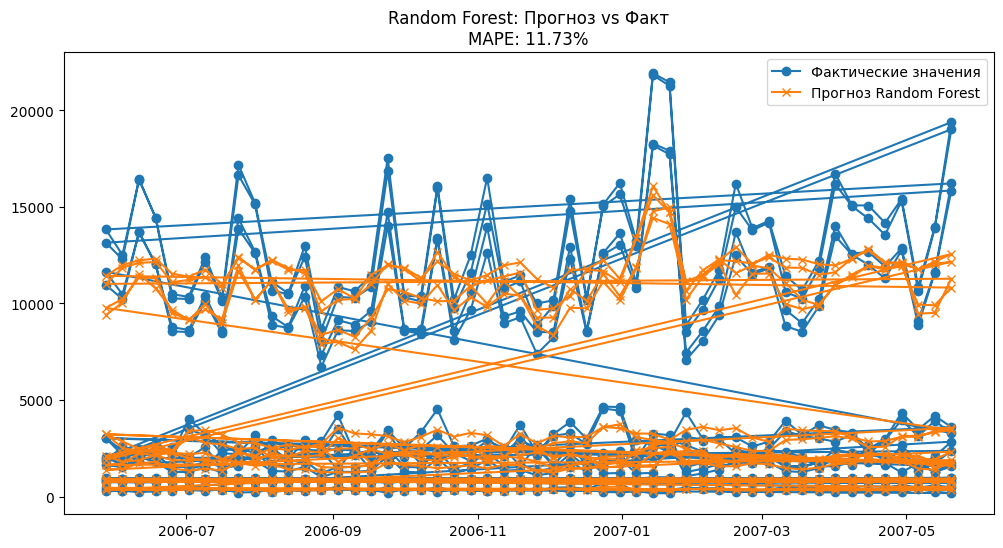

In [9]:
def train_random_forest(x_train, x_test, y_train, y_test, n_estimators=100):
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=10,
        min_samples_split=5,
        n_jobs=-1 
    )
    
    rf_model.fit(x_train, y_train)
    
    y_pred = rf_model.predict(x_test)
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Random Forest MAPE: {mape:.4f} ({mape*100:.2f}%)")
    print(f"Random Forest RMSE: {rmse:.0f}")
    
    return rf_model, y_pred, mape


rf_model, y_pred, rf_mape = train_random_forest(x_train, x_test, y_train, y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Фактические значения', marker='o')
plt.plot(y_test.index, y_pred, label='Прогноз Random Forest', marker='x')
plt.title(f'Random Forest: Прогноз vs Факт\nMAPE: {rf_mape*100:.2f}%')
plt.legend()
plt.show()

In [10]:
df

,price,promotion,revenue,year,month,month_sin,month_cos,week,week_sin,week_cos,...,revenue_rolling_trend_4,revenue_rolling_trend_8,type_tblre,type_tblwt,type_value,type_vinta,region_reg1,region_reg2,region_reg3,region_reg4
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-22,0.103900,0,6907.0,2004,2,0.866025,5.000000e-01,8,-0.866025,-0.5,...,NaN,NaN,1,0,0,0,1,0,0,0
2004-02-29,0.104790,0,4350.0,2004,2,0.866025,5.000000e-01,9,-1.0,-0.0,...,NaN,NaN,1,0,0,0,1,0,0,0
2004-03-07,0.102735,0,3833.0,2004,3,1.000000,6.123234e-17,10,-0.866025,0.5,...,NaN,NaN,1,0,0,0,1,0,0,0
2004-03-14,0.106229,0,3746.0,2004,3,1.000000,6.123234e-17,11,-0.5,0.866025,...,NaN,NaN,1,0,0,0,1,0,0,0
2004-03-21,0.106297,0,4302.0,2004,3,1.000000,6.123234e-17,12,-0.0,1.0,...,-0.412516,NaN,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-04-20,0.388516,0,15844.0,2008,4,0.866025,-5.000000e-01,16,0.866025,-0.5,...,NaN,NaN,0,0,0,1,0,0,0,1
2008-04-27,0.282264,0,15844.0,2008,4,0.866025,-5.000000e-01,17,0.5,-0.866025,...,NaN,NaN,0,0,0,1,0,0,0,1
2008-05-04,0.188003,0,15844.0,2008,5,0.500000,-8.660254e-01,18,0.0,-1.0,...,NaN,NaN,0,0,0,1,0,0,0,1


In [11]:
def time_series_grid_search(X, y, param_grid, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    rf = RandomForestRegressor(n_jobs=-1)
    
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=tscv,
        scoring=mape_scorer,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    
    print("лучшие параметры:", grid_search.best_params_)
    print("лучший MAPE:", -grid_search.best_score_)
    
    return grid_search.best_estimator_, grid_search.best_params_


feature_columns = [col for col in df.columns if col != 'revenue']
x = df[feature_columns]
y = df['revenue']

train_mask = df.index < '2006-05-28'
x_train_val = x_train
y_train_val = y_train

print(f"данные для Grid Search: {x_train_val.shape}")


param_grid_extended = {
        'n_estimators': [200, 300],  
        'max_depth': [10, 15, 20, None],      
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
        'bootstrap': [True],
        'max_samples': [0.7, 0.8, 0.9, None]   
    }

best_model, best_params = time_series_grid_search(
    x_train_val, y_train_val, param_grid_extended, n_splits=3
)

данные для Grid Search: (1888, 43)
Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
лучшие параметры: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'max_samples': 0.9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
лучший MAPE: 0.7090293406478665


Random Forest MAPE: 0.1280 (12.80%)
Random Forest RMSE: 1274


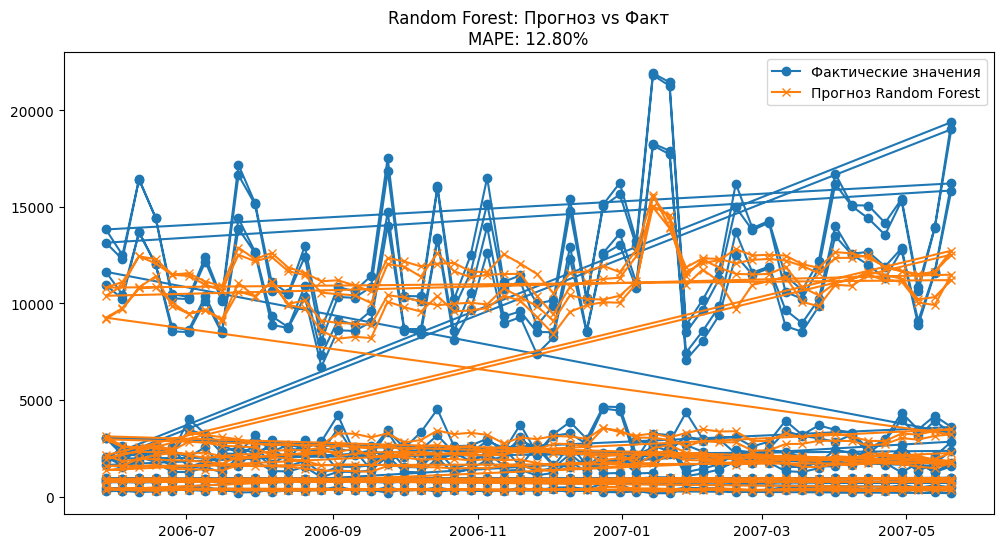

In [12]:

y_pred = best_model.predict(x_test)
    
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
print(f"Random Forest MAPE: {mape:.4f} ({mape*100:.2f}%)")
print(f"Random Forest RMSE: {rmse:.0f}")
    

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Фактические значения', marker='o')
plt.plot(y_test.index, y_pred, label='Прогноз Random Forest', marker='x')
plt.title(f'Random Forest: Прогноз vs Факт\nMAPE: {mape*100:.2f}%')
plt.legend()
plt.show()

In [15]:
def optimize_xgboost(x_train, y_train, n_iter):

    param_distributions = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1, 5],
        'reg_lambda': [0, 0.1, 0.5, 1, 5],
        'min_child_weight': [1, 3, 5, 7]
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        verbosity=0
    )
    
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    

    search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=n_iter,  
        cv=tscv,
        scoring=mape_scorer,
        n_jobs=-1,
        verbose=1
    )
  
    search.fit(x_train, y_train)
    
    print("Лучшие параметры:", search.best_params_)
    print("Лучший MAPE:", -search.best_score_)
    
    return search.best_estimator_, search.best_params_

optimized_xgb, best_xgb_params = optimize_xgboost(
    x_train, y_train, n_iter=500
)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Лучшие параметры: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.15, 'colsample_bytree': 0.6}
Лучший MAPE: 0.3071737285681981


XGB MAPE: 0.1102 (11.02%)
XGB RMSE: 1218


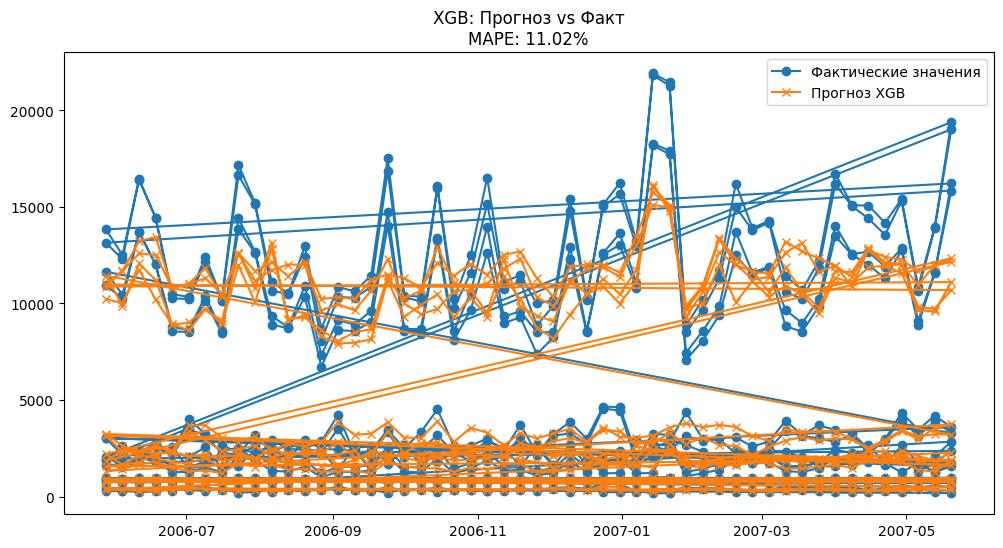

In [16]:
y_pred = optimized_xgb.predict(x_test)
    
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
print(f"XGB MAPE: {mape:.4f} ({mape*100:.2f}%)")
print(f"XGB RMSE: {rmse:.0f}")
    

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Фактические значения', marker='o')
plt.plot(y_test.index, y_pred, label='Прогноз XGB', marker='x')
plt.title(f'XGB: Прогноз vs Факт\nMAPE: {mape*100:.2f}%')
plt.legend()
plt.show()

In [14]:
def final_forecast(df, target_col, model, final_date='2007-05-20', forecast_steps=26):

    train_data = df[df.index <= final_date].copy()
    feature_columns = [col for col in train_data.columns if col != target_col]
    
    future_dates = pd.date_range(
        start=train_data.index[-1] + pd.Timedelta(weeks=1),
        periods=forecast_steps,
        freq='W'
    )
    
    future_forecast = []
    lower_bounds = []
    upper_bounds = []
    
    current_data = train_data.copy()
    
    for i in range(forecast_steps):
        last_row = current_data.iloc[[-1]][feature_columns]
        
        prediction = model.predict(last_row)[0]
        future_forecast.append(prediction)
        
     
        uncertainty = prediction * 0.1 
        lower_bounds.append(prediction - uncertainty)
        upper_bounds.append(prediction + uncertainty)
        
        new_date = current_data.index[-1] + pd.Timedelta(weeks=1)
        new_row = pd.DataFrame(index=[new_date])
        new_row[target_col] = prediction
        
        for col in feature_columns:
            new_row[col] = last_row[col].iloc[0]
        
        current_data = pd.concat([current_data, new_row])
    
    forecast_df = pd.DataFrame({
        'point_forecast': future_forecast,
        'lower_95': lower_bounds,
        'upper_95': upper_bounds
    }, index=future_dates)
    
    return forecast_df


forecast_26 = final_forecast(
    df,
    'revenue',
    best_model, 
    final_date='2007-05-20',
    forecast_steps=26
)

print("прогноз на 26 недель:")
print(forecast_26.round(0))

прогноз на 26 недель:
            point_forecast  lower_95  upper_95
2007-05-27           805.0     725.0     886.0
2007-06-03           805.0     725.0     886.0
2007-06-10           805.0     725.0     886.0
2007-06-17           805.0     725.0     886.0
2007-06-24           805.0     725.0     886.0
2007-07-01           805.0     725.0     886.0
2007-07-08           805.0     725.0     886.0
2007-07-15           805.0     725.0     886.0
2007-07-22           805.0     725.0     886.0
2007-07-29           805.0     725.0     886.0
2007-08-05           805.0     725.0     886.0
2007-08-12           805.0     725.0     886.0
2007-08-19           805.0     725.0     886.0
2007-08-26           805.0     725.0     886.0
2007-09-02           805.0     725.0     886.0
2007-09-09           805.0     725.0     886.0
2007-09-16           805.0     725.0     886.0
2007-09-23           805.0     725.0     886.0
2007-09-30           805.0     725.0     886.0
2007-10-07           805.0     725.0  